In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [2]:
def grad_cam_plus(model, img,
                  layer_name="block5_conv3", label_name=None,
                  category_id=None):
    """Get a heatmap by Grad-CAM++.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name is not None:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

In [3]:
import requests
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_file


WEIGHTS_PATH_VGG16_MURA = "https://github.com/samson6460/tf_keras_gradcamplusplus/releases/download/Weights/tf_keras_vgg16_mura_model.h5"

def vgg16_mura_model():
    """Get a vgg16 model.

    The model can classify bone X-rays into three categories:
    wrist, shoulder and elbow.
    It will download the weights automatically for the first time.

    Return:
        A tf.keras model object.
    """
    path_weights = get_file(
        "tf_keras_vgg16_mura_model.h5",
        WEIGHTS_PATH_VGG16_MURA,
        cache_subdir="models")

    model = load_model(path_weights)

    return model


def preprocess_image(img_path, target_size=(224, 224)):
    """Preprocess the image by reshape and normalization.

    Args:
        img_path: A string.
        target_size: A tuple, reshape to this size.
    Return:
        An image array.
    """
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img /= 255

    return img


def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    """Show the image with heatmap.

    Args:
        img_path: string.
        heatmap: image array, get it by calling grad_cam().
        alpha: float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # ADDED ##################################################################################################
    superimposed_img = heatmap * alpha
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    plt.imshow(superimposed_img)
    plt.show()

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)
    try:
        display(imgwithheat)
        #plt.imshow(imgwithheat)
        #plt.title("Grad-CAM++")
    except NameError:
        imgwithheat.show()

    if return_array:
        return superimposed_img

In [4]:
# %% load the model
model = vgg16_mura_model()
model.summary()

# %%
img_path = 'Images\welpe.jpg'
img = preprocess_image(img_path)

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

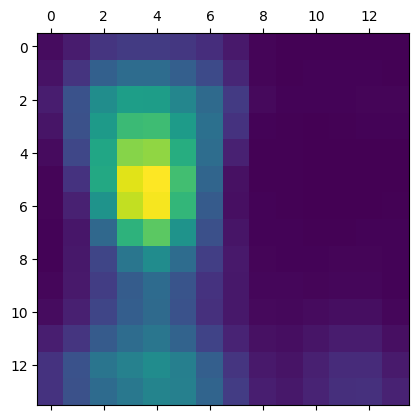

In [5]:
# %% result of grad cam++
heatmap_plus = grad_cam_plus(model, img)
#show_imgwithheat(img_path, heatmap_plus)
# Display heatmap
plt.matshow(heatmap_plus)
# Grobe Darstellung der Bereiche im Bild
plt.show()

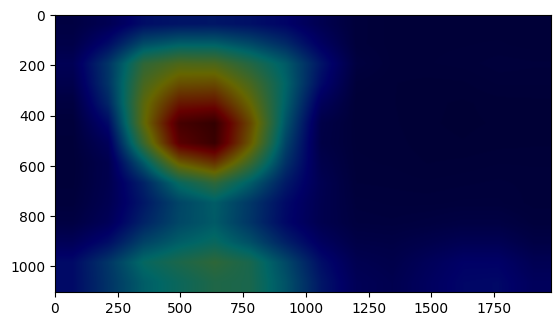

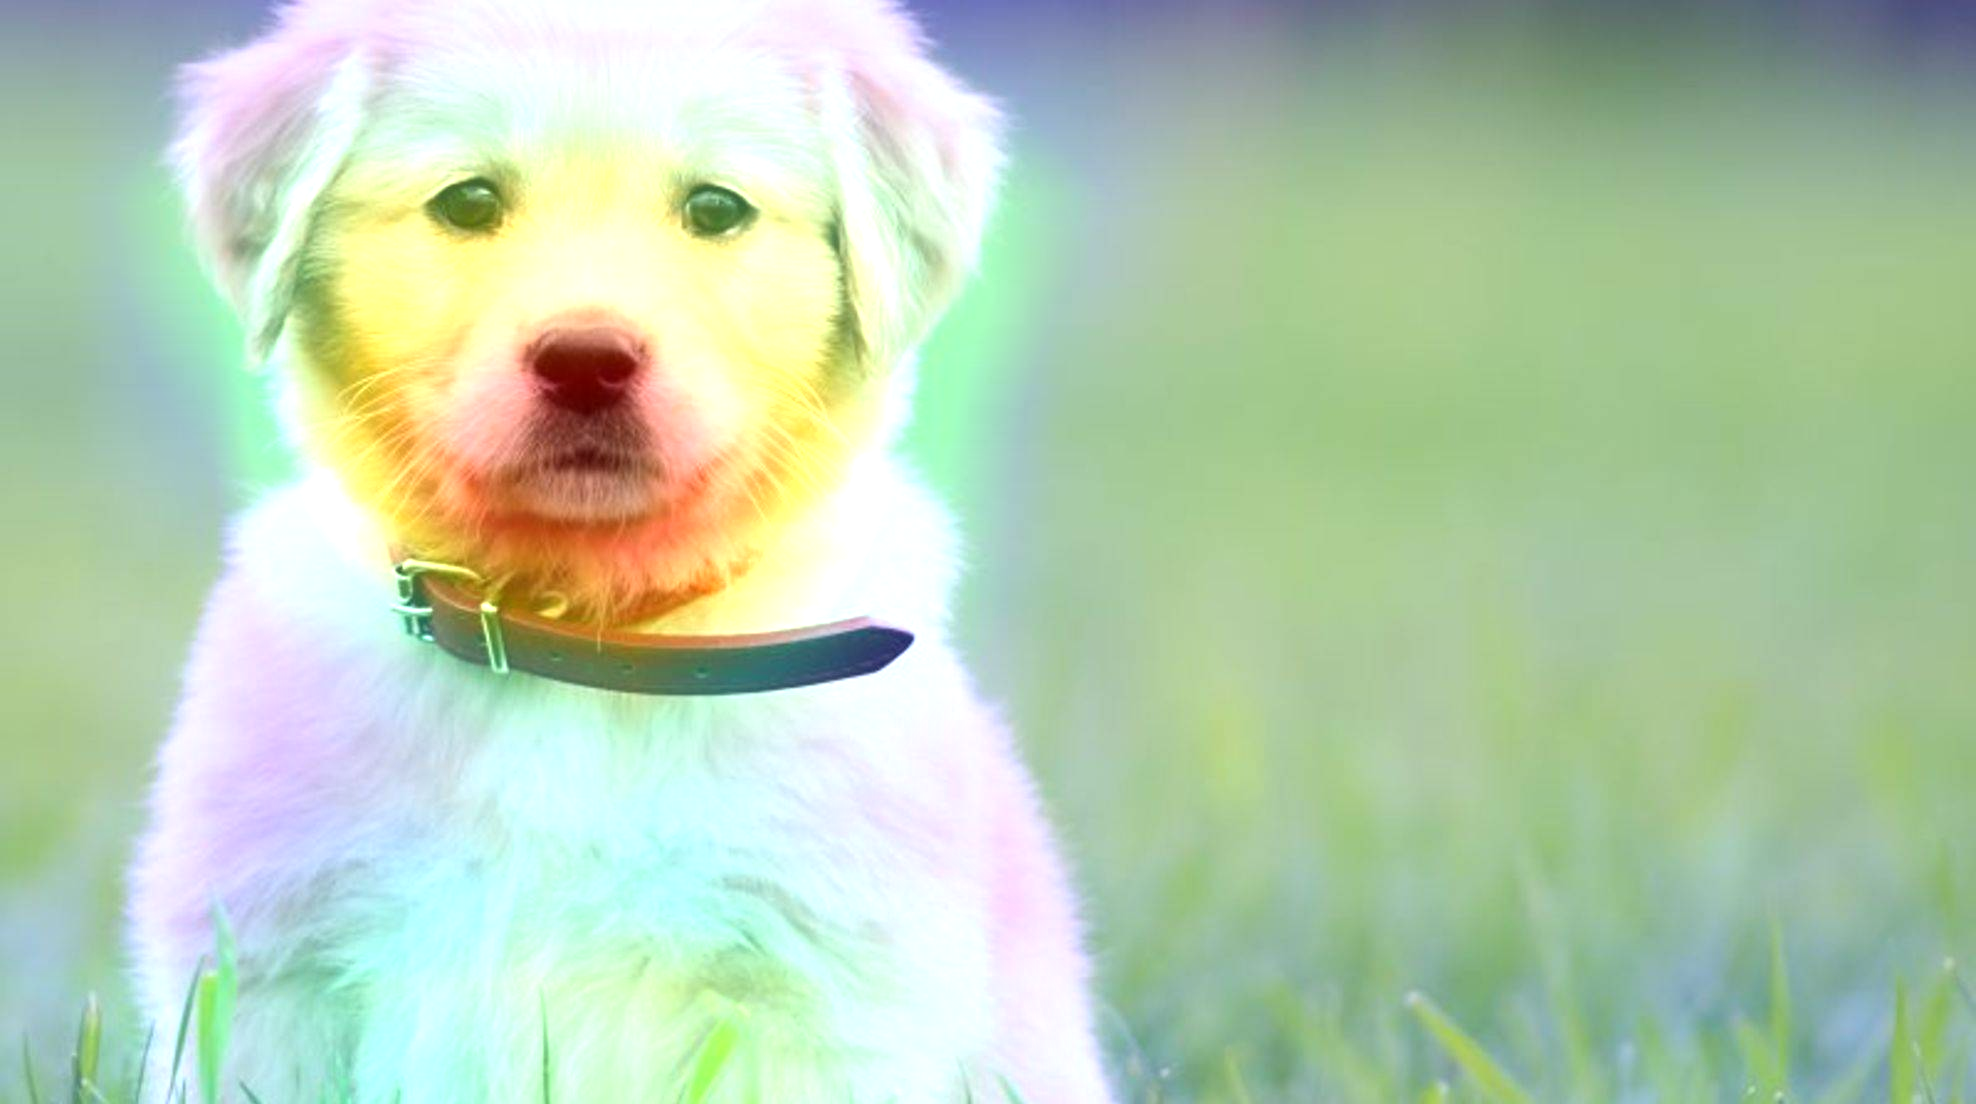

In [6]:
show_imgwithheat(img_path, heatmap_plus)